In [1]:
import os
from pathlib import Path

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle: path = Path('../input/cartrain')
else:
    path = Path('')
    if not path.exists():
        import zipfile,kaggle
        kaggle.api.competition_download_cli(str(path))
        zipfile.ZipFile(f'{path}.zip').extractall(path)

In [2]:
import torch, numpy as np, pandas as pd
np.set_printoptions(linewidth=140)
torch.set_printoptions(linewidth=140, sci_mode=False, edgeitems=7)
pd.set_option('display.width', 140)

In [3]:
df = pd.read_csv(path/'train.csv')

In [4]:
df

,model,year,motor_type,running,wheel,color,type,status,motor_volume,price
0,toyota,2022,petrol,3000 km,left,skyblue,sedan,excellent,2.0,24500
1,mercedes-benz,2014,petrol,132000 km,left,black,sedan,excellent,2.0,25500
2,kia,2018,petrol,95000 miles,left,other,sedan,excellent,2.0,11700
3,mercedes-benz,2002,petrol,137000 miles,left,golden,sedan,excellent,3.2,12000
4,mercedes-benz,2017,petrol,130000 km,left,black,sedan,good,2.0,26000
...,...,...,...,...,...,...,...,...,...,...
1637,hyundai,2017,petrol,120000 miles,left,white,sedan,good,2.0,12400
1638,toyota,2014,petrol,170000 km,left,black,sedan,good,2.0,16500
1639,nissan,2018,petrol,68900 miles,left,blue,suv,good,2.0,19500
1640,nissan,2019,petrol,31000 miles,left,black,suv,excellent,2.0,19500


In [5]:
df.isna().sum()

model           0
year            0
motor_type      0
running         0
wheel           0
color           0
type            0
status          0
motor_volume    0
price           0
dtype: int64

In [6]:
modes = df.mode().iloc[0]
modes

model           mercedes-benz
year                     2019
motor_type             petrol
running            300000  km
wheel                    left
color                   black
type                    sedan
status              excellent
motor_volume              2.0
price                   15750
Name: 0, dtype: object

In [7]:
df.fillna(modes, inplace=True)

We can now check there's no missing values left:

In [8]:
df.isna().sum()

model           0
year            0
motor_type      0
running         0
wheel           0
color           0
type            0
status          0
motor_volume    0
price           0
dtype: int64

In [9]:
import numpy as np

df.describe(include=(np.number))

,year,motor_volume,price
count,1642.000000,1642.000000,1642.000000
mean,2014.805725,2.035018,15982.633374
std,6.587573,0.253069,7176.084647
min,1987.000000,0.200000,462.000000
25%,2013.000000,2.000000,12000.000000
50%,2017.000000,2.000000,15750.000000
75%,2019.000000,2.000000,18500.000000
max,2023.000000,4.000000,87000.000000


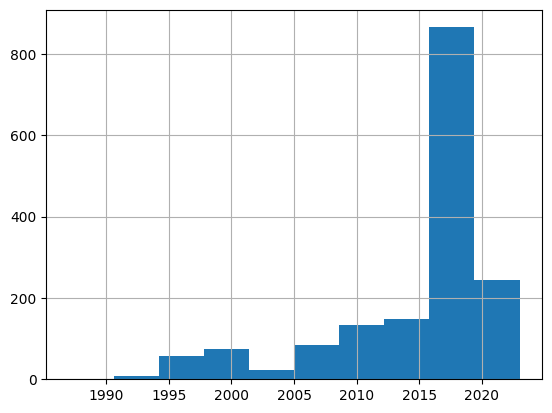

In [10]:
df['year'].hist();

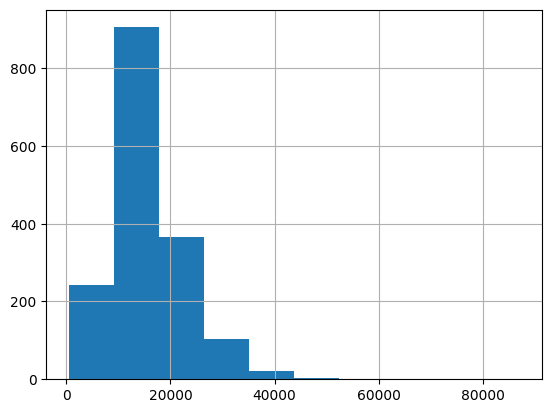

In [11]:
df['price'].hist();

In [12]:
df.describe(include=[object])

,model,motor_type,running,wheel,color,type,status
count,1642,1642,1642,1642,1642,1642,1642
unique,5,5,643,1,17,7,5
top,mercedes-benz,petrol,300000 km,left,black,sedan,excellent
freq,402,1420,19,1642,541,1276,1200


In [13]:
indep_cols = ['model', 'year', 'motor_type', 'running', 'color', 'type', 'status', 'motor_volume']

In [14]:
df[indep_cols].dtypes
df[indep_cols].head()

,model,year,motor_type,running,color,type,status,motor_volume
0,toyota,2022,petrol,3000 km,skyblue,sedan,excellent,2.0
1,mercedes-benz,2014,petrol,132000 km,black,sedan,excellent,2.0
2,kia,2018,petrol,95000 miles,other,sedan,excellent,2.0
3,mercedes-benz,2002,petrol,137000 miles,golden,sedan,excellent,3.2
4,mercedes-benz,2017,petrol,130000 km,black,sedan,good,2.0


In [15]:
df['running'].dtype
df['running'].head()

0         3000  km
1       132000  km
2     95000  miles
3    137000  miles
4       130000  km
Name: running, dtype: object

In [16]:
def dataNormalize(df, mode="train"):
    from sklearn.preprocessing import LabelEncoder
    df[['number', 'unit']] = df['running'].str.split(expand=True)
    df['number'] = df['number'].astype(float)
    df.loc[df['unit'] == 'miles', 'number'] *= 1.60934
    df['running'] = df['number']  
    df.drop(columns=['number', 'unit'], inplace=True)  
    le = LabelEncoder()
    df["color"] = le.fit_transform(df["color"])
    df["type"] = le.fit_transform(df["type"])
    df["status"] = le.fit_transform(df["status"])
    if mode == "train":
        df['price'] = df['price'].astype(float)
    df["model"] = le.fit_transform(df["model"])
    df["motor_type"] = le.fit_transform(df["motor_type"])
    df["running"] = pd.to_numeric(df["running"], errors="coerce")
    color_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    color_mapping
    for i in range(len(df["wheel"])):
        df.loc[i, "wheel"] = 1 
    return df


In [17]:
df = dataNormalize(df)

In [18]:
from torch import tensor

t_indep = tensor(df[indep_cols].values, dtype=torch.float)
t_dep = tensor(df.price.values, dtype=torch.float)

In [19]:
t_dep
n_coeff = t_indep.shape[1]

In [20]:
df

,model,year,motor_type,running,wheel,color,type,status,motor_volume,price
0,4,2022,3,3000.000,1,15,5,1,2.0,24500.0
1,2,2014,3,132000.000,1,1,5,1,2.0,25500.0
2,1,2018,3,152887.300,1,10,5,1,2.0,11700.0
3,2,2002,3,220479.580,1,6,5,1,3.2,12000.0
4,2,2017,3,130000.000,1,1,5,2,2.0,26000.0
...,...,...,...,...,...,...,...,...,...,...
1637,0,2017,3,193120.800,1,16,5,2,2.0,12400.0
1638,4,2014,3,170000.000,1,1,5,2,2.0,16500.0
1639,3,2018,3,110883.526,1,2,6,2,2.0,19500.0
1640,3,2019,3,49889.540,1,1,6,1,2.0,19500.0


In [21]:
print(df.dtypes)

model             int64
year              int64
motor_type        int64
running         float64
wheel            object
color             int64
type              int64
status            int64
motor_volume    float64
price           float64
dtype: object


In [22]:
t_indep = tensor(df[indep_cols].values, dtype=torch.float)

Here's the number of rows and columns we have for our independent variables:

In [23]:
t_indep.shape

torch.Size([1642, 8])

In [24]:
print(torch.cuda.is_available())
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

True


In [25]:
def one_epoch(coeffs, optimizer, lr):
    optimizer.zero_grad()
    loss = calc_loss(coeffs, trn_indep, trn_dep)
    loss.backward()
    optimizer.step()
    return round(loss.item(), 3)


In [26]:
from fastai.data.transforms import RandomSplitter
trn_split,val_split=RandomSplitter(seed=42)(df)

In [27]:
t_indep = tensor(df[indep_cols].values, dtype=torch.float)
feature_mean = t_indep.mean(dim=0)
feature_std = t_indep.std(dim=0)

In [28]:
trn_indep,val_indep = t_indep[trn_split],t_indep[val_split]
trn_dep,val_dep = t_dep[trn_split],t_dep[val_split]

In [29]:
trn_indep = (trn_indep - feature_mean) / feature_std
val_indep = (val_indep - feature_mean) / feature_std
trn_dep_mean = trn_dep.mean()
trn_dep_std = trn_dep.std()
trn_dep = (trn_dep - trn_dep_mean) / trn_dep_std
val_dep = (val_dep - trn_dep_mean) / trn_dep_std

In [30]:
print("trn_dep dtype:", trn_dep.dtype)
print("val_dep dtype:", val_dep.dtype)

trn_dep dtype: torch.float32
val_dep dtype: torch.float32


In [31]:
trn_indep = trn_indep.to(device)
trn_dep = trn_dep.to(device)
val_indep = val_indep.to(device)
val_dep = val_dep.to(device)

In [32]:
def update_coeffs(coeffs, lr):
    coeffs.sub_(coeffs.grad * lr)
    coeffs.grad.zero_()

In [33]:
n_coeff = trn_indep.shape[1] 
n_coeff

8

In [34]:
import torch
import torch.nn as nn

class CustomNN(nn.Module):
    def __init__(self, n_coeff):
        super(CustomNN, self).__init__()
        self.fc1 = nn.Linear(n_coeff, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, 1)
        self.activation = nn.ReLU()
    
    def forward(self, x):
        x = self.activation(self.fc1(x))
        x = self.activation(self.fc2(x))
        return self.fc3(x)

def init_coeffs():
    model = CustomNN(n_coeff)
    return model.to(device)


In [35]:
def calc_preds(coeffs, indeps, denormalize=False):
    preds = coeffs(indeps)
    if denormalize:
        preds = preds * trn_dep_std + trn_dep_mean
    return preds
def calc_loss(coeffs, indeps, deps): 
    return torch.nn.functional.mse_loss(calc_preds(coeffs, indeps, denormalize=False), deps.view(-1, 1))

In [36]:
def show_coeffs():
    return dict(zip(indep_cols, coeffs.fc1.weight.detach().cpu().numpy()))

In [37]:
def acc(coeffs): return (val_dep.bool()==(calc_preds(coeffs, val_indep)>0.5)).float().mean()

In [38]:
losses = []
def train_model(epochs=5000, lr=0.001):
    torch.manual_seed(442)
    coeffs = init_coeffs()
    optimizer = torch.optim.Adam(coeffs.parameters(), lr=lr)
    for i in range(epochs): 
        loss = one_epoch(coeffs, optimizer, lr=lr)
        losses.append(loss)
    return coeffs

In [39]:
print(f"Using device: {device}") 
coeffs = train_model()

Using device: cuda


In [40]:
rloss = losses[:]
rloss.reverse()
print(losses[-1])
idx = 0
minv = float('inf')
for i,val in enumerate(losses):
    if val < minv:
        minv = val
        idx = i
print(idx,minv)


0.074
4931 0.074


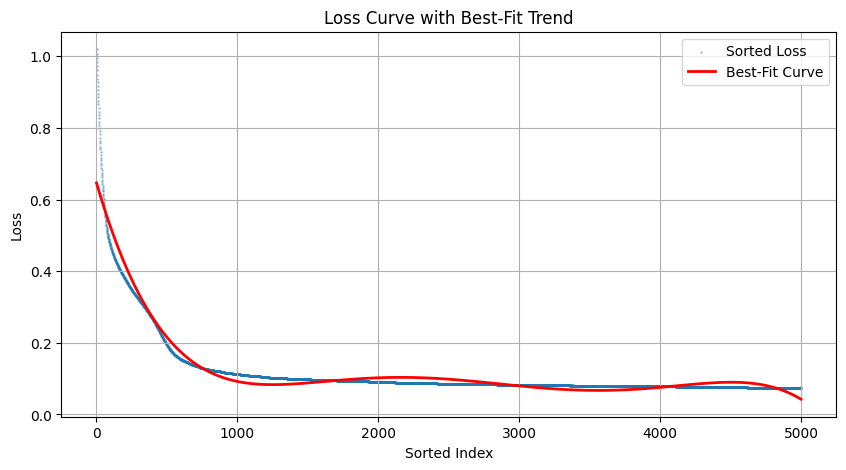

In [41]:
import numpy as np
import matplotlib.pyplot as plt
losses_sorted = losses
shotenloss = losses[6500:6900]
epochs = np.arange(1, len(losses_sorted) + 1) 

poly_coeffs = np.polyfit(epochs, losses_sorted, deg=5) 
smooth_curve = np.polyval(poly_coeffs, epochs)

plt.figure(figsize=(10, 5))
plt.scatter(epochs, losses_sorted, s=1, label="Sorted Loss", alpha=0.3)  
plt.plot(epochs, smooth_curve, color="red", linewidth=2, label="Best-Fit Curve")  

plt.xlabel("Sorted Index")
plt.ylabel("Loss")
plt.title("Loss Curve with Best-Fit Trend")
plt.legend()
plt.grid()

plt.show()

In [42]:
preds = calc_preds(coeffs, trn_indep)

In [43]:
print(f"preds dtype: {preds.dtype}, shape: {preds.shape}, min: {preds.min().item()}, max: {preds.max().item()}")
print(f"trn_dep dtype: {trn_dep.dtype}, shape: {trn_dep.shape}, min: {trn_dep.min().item()}, max: {trn_dep.max().item()}")

preds dtype: torch.float32, shape: torch.Size([1314, 1]), min: -1.8555055856704712, max: 9.991864204406738
trn_dep dtype: torch.float32, shape: torch.Size([1314]), min: -1.9053051471710205, max: 9.90052604675293


In [44]:
acc(coeffs)

tensor(0.2683, device='cuda:0')

In [45]:
show_coeffs()

{'model': array([-1.0969512 , -0.07970248,  0.3241973 , -0.13789266, -0.16757502, -0.15545435, -0.07152127,  0.52653193], dtype=float32),
 'year': array([ 0.54021454, -0.59752667,  0.34681675,  0.4803781 ,  0.0555432 , -0.0288152 , -0.43801272,  0.41833934], dtype=float32),
 'motor_type': array([-1.0863116 , -0.09032356,  0.11651357, -0.02876612, -0.09225291,  0.9460719 , -0.03593494, -0.09867609], dtype=float32),
 'running': array([ 0.56000054,  0.07560035, -0.03153471, -0.03901253,  0.4215877 , -0.35106784, -0.18622759,  0.5491186 ], dtype=float32),
 'color': array([ 1.1255091 ,  0.25600344,  0.11957487,  0.1117321 ,  0.01305657, -0.26794195,  0.00647894, -0.02480522], dtype=float32),
 'type': array([-0.30390403, -0.2575195 ,  0.26348236, -0.23377955,  0.71873593,  0.70225626,  0.01469602, -0.15143202], dtype=float32),
 'status': array([-0.6239609 ,  0.22092248,  0.46623605, -0.18974502, -0.0356504 , -0.44169432,  0.09812913, -0.504383  ], dtype=float32),
 'motor_volume': array([-0.1

In [46]:
tst_df = pd.read_csv(path/'test.csv')
tst_df

,Id,model,year,motor_type,running,wheel,color,type,status,motor_volume
0,0,kia,2020,petrol,24000 km,left,black,sedan,excellent,2.0
1,1,nissan,2017,petrol,85000 miles,left,white,suv,excellent,2.0
2,2,hyundai,2021,petrol,30000 miles,left,white,sedan,excellent,2.0
3,3,kia,2018,petrol,53000 miles,left,silver,sedan,excellent,2.0
4,4,mercedes-benz,2003,petrol,230000 km,left,black,Universal,normal,1.8
...,...,...,...,...,...,...,...,...,...,...
406,406,nissan,2021,petrol,33400 km,left,black,suv,excellent,2.0
407,407,hyundai,2017,petrol,60000 miles,left,other,sedan,excellent,2.0
408,408,mercedes-benz,2012,petrol,218000 km,left,white,sedan,good,2.0
409,409,kia,2020,petrol,40000 miles,left,red,sedan,good,2.0


In [47]:
tst_df = dataNormalize(tst_df, mode="test")
tst_df

,Id,model,year,motor_type,running,wheel,color,type,status,motor_volume
0,0,1,2020,1,24000.00,1,1,3,1,2.0
1,1,3,2017,1,136793.90,1,13,4,1,2.0
2,2,0,2021,1,48280.20,1,13,3,1,2.0
3,3,1,2018,1,85295.02,1,11,3,1,2.0
4,4,2,2003,1,230000.00,1,1,1,4,1.8
...,...,...,...,...,...,...,...,...,...,...
406,406,3,2021,1,33400.00,1,1,4,1,2.0
407,407,0,2017,1,96560.40,1,9,3,1,2.0
408,408,2,2012,1,218000.00,1,13,3,2,2.0
409,409,1,2020,1,64373.60,1,10,3,2,2.0


In [48]:
tst_indep = tensor(tst_df[indep_cols].values, dtype=torch.float).to(device)
feature_mean = feature_mean.to(device)
feature_std = feature_std.to(device)
tst_indep = (tst_indep - feature_mean) / feature_std

In [50]:
test_preds = calc_preds(coeffs, tst_indep, denormalize=True)
submission = pd.DataFrame({
    'Id': tst_df['Id'],
    'price': test_preds.cpu().detach().numpy().flatten()
})
submission.to_csv('submission.csv', index=False)